In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#libraries for text preprocessing 
import re 
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import emoji
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')

#for text vectorization 
from sklearn.feature_extraction.text import TfidfVectorizer

#for spliting
from sklearn.model_selection import train_test_split

# Traing Models 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)


In [3]:
colnames = ['target', 'ids', 'datetime', 'flag', 'user' , 'text']
df = pd.read_csv("../data/sentiment.csv", encoding="cp1252", names=colnames, header=None)
df.head()

,target,ids,datetime,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1600000 non-null  int64 
 1   ids       1600000 non-null  int64 
 2   datetime  1600000 non-null  object
 3   flag      1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [6]:
df.shape

(1600000, 6)

In [7]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [8]:
df.sample(5, random_state=42)

,target,ids,datetime,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


<h1>Map labels to binary (0 --> 0, 4 --> 1)</h1>

In [9]:
df['sentiment'] = df['target'].map({0: 0, 4: 1})
df = df[['text', 'sentiment']]

In [10]:
df.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [11]:
df_small = df.sample(n=200000, random_state=42)

<h1>Text Cleaning  & Preprocessing </h1>
goal: remove noise, normalize text, and keep sentiment-rich information.
<p>re ---> for regex (pattern-based cleaning)<br>
nltk ---> for stopwords and lemmatization<br>
emoji ---> to handle emojis properly</p>

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(text):
    try:
        #1 Lowecase
        text = text.lower()

        #2 Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", ' ', text)

        #3 Remove user mentions 
        text = re.sub(r'@\w+', ' ', text)

        #4 Remove hashtags symbol but keep the word 
        text = re.sub(r'#', '', text)

        # 5. Remove retweet "RT"
        text = re.sub(r'\brt\b', '', text)
        #5 Remove punctuation, numbers, special chars
        text = re.sub(r'[^A-Za-z\s]',' ',text)


        #6 Tokenize
        tokens = nltk.word_tokenize(text)

        #7 Remove stopwords and short words 
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

        #8 Lemmatize (convert "running" -> "run")
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        #9 Handle emojis ( convert to words)
        text = emoji.demojize(" ".join(tokens))

        #10 Remove extra whitespace
        text = re.sub(r'\s+', ' ',text).strip()
    except LookupError as e:
        print(e)
        raise
    return text

df['clean_text'] = df['text'].apply(clean_tweet)

In [13]:
df.head(20)

,text,sentiment,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,0,upset update facebook texting might cry result...
2,@Kenichan I dived many times for the ball. Man...,0,dived many time ball managed save rest bound
3,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,"@nationwideclass no, it's not behaving at all....",0,behaving mad see
5,@Kwesidei not the whole crew,0,whole crew
6,Need a hug,0,need hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,0,hey long time see yes rain bit bit lol fine th...
8,@Tatiana_K nope they didn't have it,0,nope
9,@twittera que me muera ?,0,que muera


<h1>Text Vectorization (turning text into numbers)</h1>

In [14]:
# Intialize the vectorizer 
tfidf = TfidfVectorizer(
    max_features=5000,    #use top 5000 words (limits vocabulary to most frequent words)
    ngram_range=(1,2),    # use single words and pairs of words  (1,2) means unigram and bigrams --captures context like "not good "
    stop_words='english'  # Remove stopwords  (buit-in stopword for efficiency)
)  

In [15]:
X = tfidf.fit_transform(df['clean_text'])
# fit() -- learns all unique words and their IDF scores
# transform() -- converts each tweet into a sparse numeric vector
# so now:
#---- each row = one tweet 
#---- each column = one feature (word or bigram)
#---- each cell = TF-IDF score
y = df['sentiment']

<h2>Train -- Test Split </h2>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)

In [17]:
print(X.shape)
print(tfidf.get_feature_names_out()[:20])

(1600000, 5000)
['aaah' 'aah' 'aaron' 'abc' 'ability' 'abit' 'able' 'able make'
 'able sleep' 'absolute' 'absolutely' 'abt' 'accent' 'accept' 'accepted'
 'access' 'accident' 'accidentally' 'accomplished' 'according']


In [18]:
df['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

In [19]:
# Defining three baseline Models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

# Cross - Validation 
result = {}
scoring=['roc_auc', 'accuracy', 'f1']
for name,model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    print(name)
    for metric in scoring:
        print(f" {metric}: {np.mean(scores['test_'+metric]):.4f}(+/- {np.std(scores['test_'+metric]):.4f})")
    print()


Logistic Regression
 roc_auc: 0.8429(+/- 0.0004)
 accuracy: 0.7616(+/- 0.0005)
 f1: 0.7687(+/- 0.0007)

Naive Bayes
 roc_auc: 0.8306(+/- 0.0002)
 accuracy: 0.7470(+/- 0.0003)
 f1: 0.7454(+/- 0.0004)

Linear SVM
 roc_auc: 0.8425(+/- 0.0002)
 accuracy: 0.7609(+/- 0.0005)
 f1: 0.7691(+/- 0.0006)



<h2> Hyperparameter Tuning </h2>

In [20]:
# Logistic Regression Tuning 
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X_train, y_train)

print("Best params (LogReg):", grid_lr.best_params_)
print("Best Score:", grid_lr.best_score_)
# C: Inverse of regularization strength -- smaller = stronger regularization
# solver: Algorithm for optimization (liblinear and saga work well for text)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params (LogReg): {'C': 1, 'solver': 'saga'}
Best Score: 0.7690752882561701


In [21]:
# SVM Tuning 
param_grid_svm = {
    'C': [0.1, 1, 10]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_svm.fit(X_train, y_train)

print("Best Params (SVM):", grid_svm.best_params_)
print("Best F1 Score:", grid_svm.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params (SVM): {'C': 0.1}
Best F1 Score: 0.7692450689968978


<h2>Model Evaluation & Interpretation</h2>

In [22]:
best_model = LogisticRegression(C=1, max_iter=1000, solver='liblinear')
best_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [23]:
y_pred = best_model.predict(X_test)

In [24]:
best_model1 = LinearSVC( C=0.1)
best_model1.fit(X_train, y_train)

LinearSVC(C=0.1)

In [25]:
y_pred1 = best_model1.predict(X_test)

In [26]:
# for Logistic Regression
print("For Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

For Logistic Regression
Accuracy: 0.762134375
Precision: 0.7474329879375355
Recall: 0.7941073853936924
F1 Score: 0.7700635884423097
ROC-AUC: 0.762032939565067

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75    159494
           1       0.75      0.79      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [27]:
# for SVM
print("For SVM")
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Precision:", precision_score(y_test, y_pred1))
print("Recall:", recall_score(y_test, y_pred1))
print("F1 Score:", f1_score(y_test, y_pred1))
print("ROC-AUC:", roc_auc_score(y_test, y_pred1))

print("\nClassification Report:\n", classification_report(y_test, y_pred1))

For SVM
Accuracy: 0.761290625
Precision: 0.7448408748246335
Recall: 0.7971726913635627
F1 Score: 0.7701187821444586
ROC-AUC: 0.7611767879554718

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75    159494
           1       0.74      0.80      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



<h1>Confusion Matrix</h1>

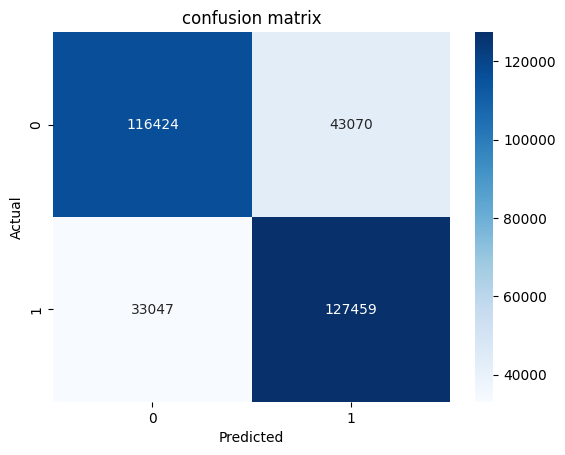

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')
plt.show()

# Interpretation:
# Top-left = True Negatives (correctly predicted negatives)
# Bottom-right = True Positives (correctly predicted positives)
# Top-right & bottom-left = errors (false predictions)


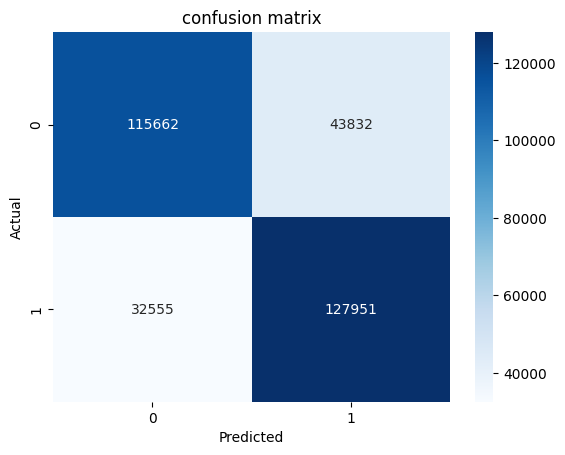

In [30]:
cm1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')
plt.show()

# Interpretation:
# Top-left = True Negatives (correctly predicted negatives)
# Bottom-right = True Positives (correctly predicted positives)
# Top-right & bottom-left = errors (false predictions)

<h2>Error Analysis </h2>
<p>Checking what kind of tweets model got wrong</p>
<p>Helps to improve  Preprocessing or add more data later </p>

In [31]:
df_test = df.iloc[y_test.index] # align test set rows
df_test['predicted'] = y_pred

wrong = df_test[df_test['sentiment'] != df_test['predicted']]
print(wrong[['clean_text', 'sentiment', 'predicted']].sample(10))

                                                clean_text  sentiment  \
438040                     lol actually yeh probably right          0   
791418                                         expensiveee          0   
85415         happy mother day guy missing mumma away home          0   
1195789                                haha miss come home          1   
1541708            today dog birthday three grow fast tear          1   
417944                                         never write          0   
277795          got little sun yesterday whole point going          0   
893976   totally forgot communist appreciation hail kre...          1   
226441   long day corona pool beating pool volleyball n...          0   
782815   nice sunny day nairobi mild degree looking for...          0   

         predicted  
438040           1  
791418           1  
85415            1  
1195789          0  
1541708          0  
417944           1  
277795           1  
893976           0  
226441 

C:\Users\hp\AppData\Local\Temp\ipykernel_65500\2473123512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted'] = y_pred


In [40]:
print(df_test.shape)
print(df_small.shape)

(320000, 4)
(200000, 2)


In [35]:
print(f" predicted values : {df_test['predicted'].value_counts()}")
print(f" values of setiment: {df['sentiment'].value_counts()}")

 predicted values : predicted
1    170529
0    149471
Name: count, dtype: int64
 values of setiment: sentiment
0    800000
1    800000
Name: count, dtype: int64


In [41]:
import joblib

# Save model
joblib.dump(best_model, 'sentiment_model.pkl')

# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
